In [1]:
import numpy as np
from numpy import eye, zeros, ones, exp, sqrt, log, r_, concatenate, diag, pi
from numpy.linalg import norm
from numpy.random import randn 
from numpy.random import default_rng
from scipy.linalg import block_diag
from scipy.optimize import fsolve
from scipy.stats import multivariate_normal as MVN

from warnings import catch_warnings, filterwarnings, resetwarnings

import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.lines as mlines

from autograd import jacobian, grad
import autograd.numpy as anp

from tangential_hug_functions import HugTangentialMultivariateSafe
from RWM import RWM
from Manifolds.Manifold import Manifold
from Manifolds.LVManifold import LVManifold
from utils import ESS_univariate, compute_arviz_miness_runtime
from Zappa.zappa import zappa_sampling_storecomps_rattle_manifold, project_zappa_manifold

import math
from scipy.linalg import qr
import scipy.linalg as la
from numpy.random import rand
from numpy.linalg import solve
import time
import pandas as pd
from arviz import convert_to_dataset
from arviz import ess as ess_arviz

from copy import deepcopy

# Settings

In [2]:
N_CHAINS = 4
SEED_DATA_GENERATION = 1111                      # Used to generate y*
SEEDS                = [2222, 3333, 4444, 5555]  # Each seed, used to find starting point of initial chain.
Z_TRUE   = (0.4, 0.005, 0.05, 0.001)
R0 = 100
F0 = 100
σR = 1
σF = 1
DISCRETIZATION_STEP_SIZE = 1.0
assert len(SEEDS) == N_CHAINS, "For reproducibility, you need to choose `N_CHAINS` random seeds."

In [3]:
def generate_settings(N, δ, Ns, Bs, ϵs, seeds, n_chains=4, u1_true=True, tol=1e-15, maxiter=5000):
    """Generates variables for the experiment."""
    manifold = LVManifold(Ns=Ns, n_chains=n_chains, seeds=seeds)
    u0s = manifold.find_init_points_for_each_chain(u1_true=u1_true, tol=tol, maxiter=maxiter)
    return {
        'N': N,
        'δ': δ,
        'Ns': Ns,
        'Bs': Bs,
        'ϵs': ϵs,
        'u0s': u0s,
        'manifold': manifold,
        'n_chains': n_chains
    }

In [16]:
def cc_experiment_thug(settings, α=0.0, verbose=False):
    """Computational Cost of THUG and C-RWM."""
    verboseprint = print if verbose else lambda *a, **k: None
    ϵs, Bs = settings['ϵs'], settings['Bs']
    u0s = settings['u0s']
    δ = settings['δ']
    N = settings['N']
    q = settings['manifold'].q_dist
    J = settings['manifold'].J
    n_chains = settings['n_chains']
    ESS_TABLE = zeros((len(ϵs), len(Bs)))
    AP_TABLE  = zeros((len(ϵs), len(Bs)))
    for ϵ_ix, ϵ in enumerate(ϵs):
        logηϵ = settings['manifold'].generate_logpi(ϵ)
        for B_ix, B in enumerate(Bs):
            chains = []
            times  = []
            avg_ap = 0.0
            for chain_ix in range(n_chains):
                start_time = time.time()
                s, a = HugTangentialMultivariateSafe(u0s[chain_ix, :], B*δ, B, N, α, q, logηϵ, J)
                runtime = time.time() - start_time
                verboseprint("B={} time={} a={}".format(B, runtime, a.mean()))
                chains.append(s)
                times.append(runtime)
                avg_ap += (a.mean() / n_chains)
            ESS_TABLE[ϵ_ix, B_ix] = compute_arviz_miness_runtime(chains, times)
            AP_TABLE[ϵ_ix, B_ix]  = avg_ap
    return ESS_TABLE, AP_TABLE

def cc_experiment_crwm(settings, tol=1e-11, rev_tol=1e-8, verbose=False):
    """Same as above but for C-RWM."""
    verboseprint = print if verbose else lambda *a, **k: None
    Bs = settings['Bs']
    u0s = settings['u0s']
    manifold = settings['manifold']
    N = settings['N']
    δ = settings['δ']
    n_chains = settings['n_chains']
    ESS_TABLE = zeros(len(Bs))
    AP_TABLE  = zeros(len(Bs))
    for B_ix, B in enumerate(Bs):
        chains = []
        times  = []
        avg_ap = 0.0
        for chain_ix in range(n_chains):
            start_time = time.time()
            s, e, a = zappa_sampling_storecomps_rattle_manifold(u0s[chain_ix, :], manifold, N, δ*B, B, tol=tol, rev_tol=rev_tol)
            runtime = time.time() - start_time
            verboseprint("B={} time={} a={}".format(B, runtime, a.mean()))
            chains.append(s)
            times.append(runtime)
            avg_ap += (a.mean() / n_chains)
        ESS_TABLE[B_ix] = compute_arviz_miness_runtime(chains, times)
        AP_TABLE[B_ix]  = avg_ap
    return ESS_TABLE, AP_TABLE

def show_only_positive_ap(cc, ap, ix):
    """USED FOR PLOTTING ONLY ESS WHERE WE HAD POSITIVE ACCEPTANCE PROBABILITY."""
    cc_copy = cc.copy()
    ap_copy = ap.copy()
    flag = ap_copy[:, ix] < 1e-8
    values = cc_copy[:, ix]
    values[flag] = np.nan
    return values

def show_only_positive_ap_crwm(out_cc, out_ap, ϵs, ix):
    """Same as above but for C-RWM."""
    cc_copy = deepcopy(out_cc.copy())
    ap_copy = deepcopy(out_ap.copy())
    flag = ap_copy < 1e-8
    cc_copy[flag] = np.nan
    return np.repeat(cc_copy[ix], len(ϵs))

# $N_s = 100$  and $\delta=0.01$

In [5]:
SETTINGS100 = generate_settings(
    N=200, 
    δ=0.01, 
    Ns=100, 
    Bs=[1, 10, 20], 
    ϵs=[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001], 
    u1_true=False,
    tol=1e-14,
    n_chains=N_CHAINS,
    seeds=SEEDS
)

In [6]:
O1, O2 = cc_experiment_thug(SETTINGS100, 0.0, verbose=False)

In [9]:
O3, O4 = cc_experiment_thug(SETTINGS100, 0.9, verbose=False)

In [10]:
O5, O6 = cc_experiment_thug(SETTINGS100, 0.99, verbose=False)

In [14]:
O7, O8 = cc_experiment_crwm(SETTINGS100, tol=1e-11, verbose=False)

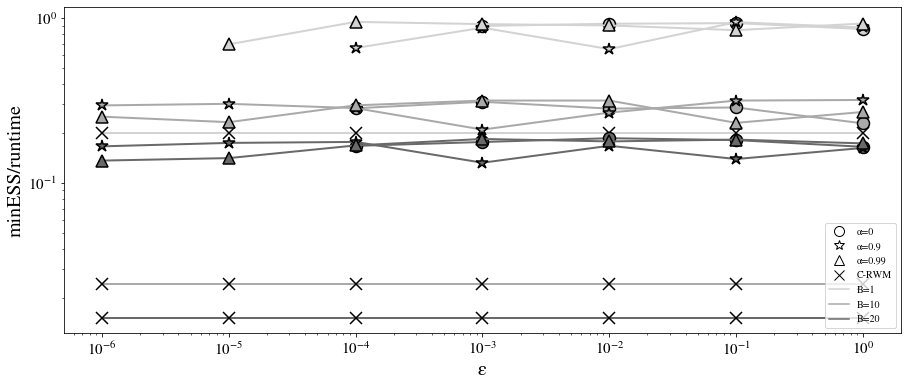

In [17]:
ϵs_100 = SETTINGS100['ϵs']
Bs_100 = SETTINGS100['Bs']
greys = ['lightgray', 'darkgrey', 'dimgrey']
MARKERSIZE = 12
LINEWIDTH  = 2
MARKEREDGEWIDTH = 1.5
CRWM_LINEWIDTH=2
rc('font',**{'family':'STIXGeneral'})
# Plot computational costs
fig, ax = plt.subplots(figsize=(15, 6))
# alpha = 0.0
for i in range(len(Bs_100)):
    ax.plot(ϵs_100, show_only_positive_ap(O1, O2, i), color=greys[i], marker='o', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_100, show_only_positive_ap(O3, O4, i), color=greys[i], marker='*', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_100, show_only_positive_ap(O5, O6, i), color=greys[i], marker='^', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_100, show_only_positive_ap_crwm(O7, O8, ϵs_100, i), marker='x', color=greys[i], markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
# Legend
triangle = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='^', linestyle='None', markersize=10, label='α=0.99')
star     = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='*', linestyle='None', markersize=10, label='α=0.9')
circle   = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='o', linestyle='None', markersize=10, label='α=0')
cross    = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='x', linestyle='None', markersize=10, label='C-RWM')
lightline  = mlines.Line2D([], [], color='lightgray', linestyle='-', label='B={}'.format(Bs_100[0]))
mediumline = mlines.Line2D([], [], color='darkgrey', linestyle='-', label='B={}'.format(Bs_100[1]))
darkline   = mlines.Line2D([], [], color='dimgrey', linestyle='-', label='B={}'.format(Bs_100[2]))
ax.legend(handles=[circle, star, triangle, cross, lightline, mediumline, darkline], loc='lower right')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r"$\mathregular{\epsilon}$", fontsize=20)
ax.set_ylabel("minESS/runtime", fontsize=20)
ax.loglog()
# plt.savefig('figures/lv_computational_cost_100.png')
plt.show()

# $N_s = 100$ and $\delta=0.05$

In [22]:
SETTINGS100_005 = generate_settings(
    N=200, 
    δ=0.05, 
    Ns=100, 
    Bs=[1, 10, 20], 
    ϵs=[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001], 
    u1_true=False,
    tol=1e-14,
    n_chains=N_CHAINS,
    seeds=SEEDS
)

In [23]:
O9, O10 = cc_experiment_thug(SETTINGS100_005, 0.0, verbose=False)

In [24]:
O11, O12 = cc_experiment_thug(SETTINGS100_005, 0.9, verbose=False)

In [25]:
O13, O14 = cc_experiment_thug(SETTINGS100_005, 0.99, verbose=False)

In [26]:
O15, O16 = cc_experiment_crwm(SETTINGS100_005, tol=1e-11, verbose=False)

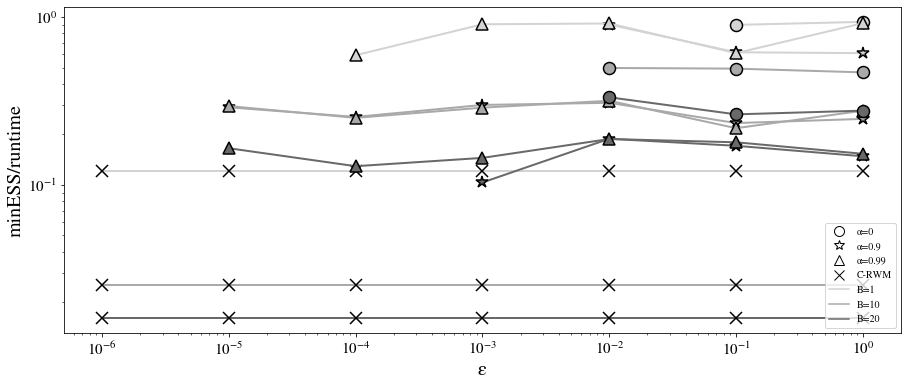

In [27]:
ϵs_100 = SETTINGS100['ϵs']
Bs_100 = SETTINGS100['Bs']
greys = ['lightgray', 'darkgrey', 'dimgrey']
MARKERSIZE = 12
LINEWIDTH  = 2
MARKEREDGEWIDTH = 1.5
CRWM_LINEWIDTH=2
rc('font',**{'family':'STIXGeneral'})
# Plot computational costs
fig, ax = plt.subplots(figsize=(15, 6))
# alpha = 0.0
for i in range(len(Bs_100)):
    ax.plot(ϵs_100, show_only_positive_ap(O9, O10, i), color=greys[i], marker='o', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_100, show_only_positive_ap(O11, O12, i), color=greys[i], marker='*', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_100, show_only_positive_ap(O13, O14, i), color=greys[i], marker='^', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_100, show_only_positive_ap_crwm(O15, O16, ϵs_100, i), marker='x', color=greys[i], markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
# Legend
triangle = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='^', linestyle='None', markersize=10, label='α=0.99')
star     = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='*', linestyle='None', markersize=10, label='α=0.9')
circle   = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='o', linestyle='None', markersize=10, label='α=0')
cross    = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='x', linestyle='None', markersize=10, label='C-RWM')
lightline  = mlines.Line2D([], [], color='lightgray', linestyle='-', label='B={}'.format(Bs_100[0]))
mediumline = mlines.Line2D([], [], color='darkgrey', linestyle='-', label='B={}'.format(Bs_100[1]))
darkline   = mlines.Line2D([], [], color='dimgrey', linestyle='-', label='B={}'.format(Bs_100[2]))
ax.legend(handles=[circle, star, triangle, cross, lightline, mediumline, darkline], loc='lower right')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r"$\mathregular{\epsilon}$", fontsize=20)
ax.set_ylabel("minESS/runtime", fontsize=20)
ax.loglog()
# plt.savefig('figures/lv_computational_cost_100.png')
plt.show()

# $N_s = 120$

In [18]:
SETTINGS120 = generate_settings(
    N=200, 
    δ=0.01, 
    Ns=120, 
    Bs=[1, 10, 20], 
    ϵs=[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001], 
    u1_true=False,
    tol=1e-14,
    n_chains=N_CHAINS,
    seeds=SEEDS
)

In [30]:
O17, O18 = cc_experiment_thug(SETTINGS120, 0.0, verbose=False)

In [33]:
O19, O20 = cc_experiment_thug(SETTINGS120, 0.9, verbose=False)

In [34]:
O21, O22 = cc_experiment_thug(SETTINGS120, 0.99, verbose=False)

In [31]:
O23, O24 = cc_experiment_crwm(SETTINGS120, tol=1e-11, verbose=False)

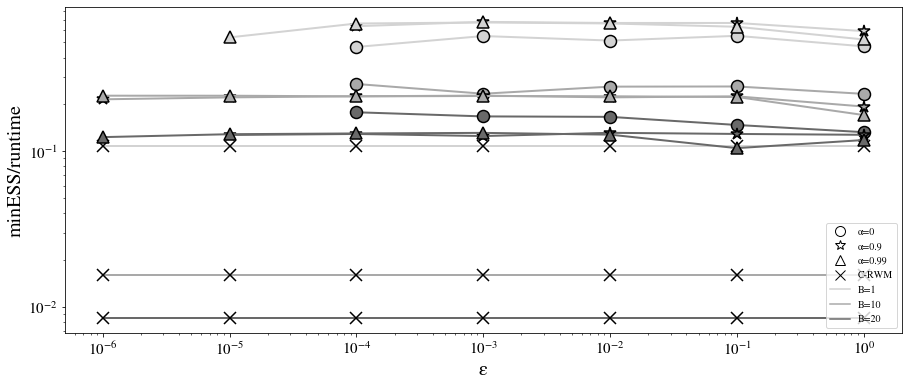

In [35]:
ϵs_100 = SETTINGS100['ϵs']
Bs_100 = SETTINGS100['Bs']
greys = ['lightgray', 'darkgrey', 'dimgrey']
MARKERSIZE = 12
LINEWIDTH  = 2
MARKEREDGEWIDTH = 1.5
CRWM_LINEWIDTH=2
rc('font',**{'family':'STIXGeneral'})
# Plot computational costs
fig, ax = plt.subplots(figsize=(15, 6))
# alpha = 0.0
for i in range(len(Bs_100)):
    ax.plot(ϵs_100, show_only_positive_ap(O17, O18, i), color=greys[i], marker='o', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_100, show_only_positive_ap(O19, O20, i), color=greys[i], marker='*', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_100, show_only_positive_ap(O21, O22, i), color=greys[i], marker='^', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_100, show_only_positive_ap_crwm(O23, O24, ϵs_100, i), marker='x', color=greys[i], markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
# Legend
triangle = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='^', linestyle='None', markersize=10, label='α=0.99')
star     = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='*', linestyle='None', markersize=10, label='α=0.9')
circle   = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='o', linestyle='None', markersize=10, label='α=0')
cross    = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='x', linestyle='None', markersize=10, label='C-RWM')
lightline  = mlines.Line2D([], [], color='lightgray', linestyle='-', label='B={}'.format(Bs_100[0]))
mediumline = mlines.Line2D([], [], color='darkgrey', linestyle='-', label='B={}'.format(Bs_100[1]))
darkline   = mlines.Line2D([], [], color='dimgrey', linestyle='-', label='B={}'.format(Bs_100[2]))
ax.legend(handles=[circle, star, triangle, cross, lightline, mediumline, darkline], loc='lower right')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r"$\mathregular{\epsilon}$", fontsize=20)
ax.set_ylabel("minESS/runtime", fontsize=20)
ax.loglog()
# plt.savefig('figures/lv_computational_cost_100.png')
plt.show()

# $N_s=120$ and $\delta=0.05$

In [36]:
SETTINGS120_005 = generate_settings(
    N=200, 
    δ=0.05, 
    Ns=120, 
    Bs=[1, 10, 20], 
    ϵs=[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001], 
    u1_true=False,
    tol=1e-14,
    n_chains=N_CHAINS,
    seeds=SEEDS
)

In [37]:
O25, O26 = cc_experiment_thug(SETTINGS120_005, 0.0, verbose=False)

In [38]:
O27, O28 = cc_experiment_thug(SETTINGS120_005, 0.9, verbose=False)

In [39]:
O29, O30 = cc_experiment_thug(SETTINGS120_005, 0.99, verbose=False)

In [40]:
O31, O32 = cc_experiment_crwm(SETTINGS120_005, tol=1e-11, verbose=False)

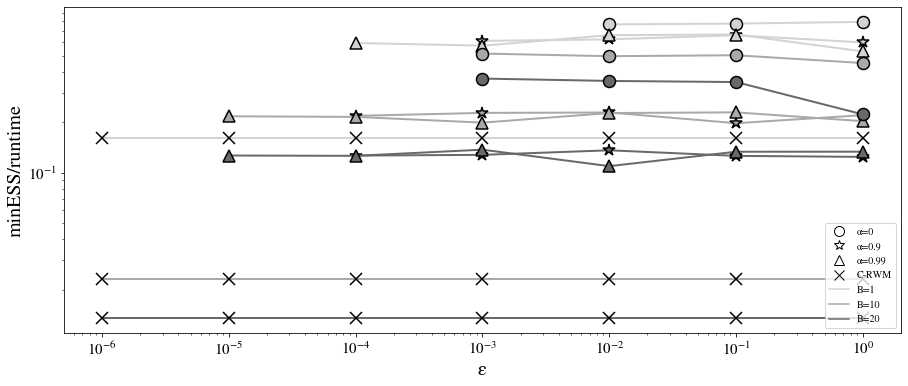

In [41]:
ϵs_120 = SETTINGS120['ϵs']
Bs_120 = SETTINGS120['Bs']
greys = ['lightgray', 'darkgrey', 'dimgrey']
MARKERSIZE = 12
LINEWIDTH  = 2
MARKEREDGEWIDTH = 1.5
CRWM_LINEWIDTH=2
rc('font',**{'family':'STIXGeneral'})
# Plot computational costs
fig, ax = plt.subplots(figsize=(15, 6))
# alpha = 0.0
for i in range(len(Bs_100)):
    ax.plot(ϵs_120, show_only_positive_ap(O25, O26, i), color=greys[i], marker='o', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_120, show_only_positive_ap(O27, O28, i), color=greys[i], marker='*', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_120, show_only_positive_ap(O29, O30, i), color=greys[i], marker='^', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_120, show_only_positive_ap_crwm(O31, O32, ϵs_120, i), marker='x', color=greys[i], markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
# Legend
triangle = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='^', linestyle='None', markersize=10, label='α=0.99')
star     = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='*', linestyle='None', markersize=10, label='α=0.9')
circle   = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='o', linestyle='None', markersize=10, label='α=0')
cross    = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='x', linestyle='None', markersize=10, label='C-RWM')
lightline  = mlines.Line2D([], [], color='lightgray', linestyle='-', label='B={}'.format(Bs_120[0]))
mediumline = mlines.Line2D([], [], color='darkgrey', linestyle='-', label='B={}'.format(Bs_120[1]))
darkline   = mlines.Line2D([], [], color='dimgrey', linestyle='-', label='B={}'.format(Bs_120[2]))
ax.legend(handles=[circle, star, triangle, cross, lightline, mediumline, darkline], loc='lower right')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r"$\mathregular{\epsilon}$", fontsize=20)
ax.set_ylabel("minESS/runtime", fontsize=20)
ax.loglog()
# plt.savefig('figures/lv_computational_cost_100.png')
plt.show()